In [ ]:
!pip install pandas openpyxl matplotlib seaborn scikit-learn joblib

from google.colab import files
uploaded = files.upload()


Saving bert_embeddings_with_syntax.csv to bert_embeddings_with_syntax (1).csv


In [ ]:
import pandas as pd

df = pd.read_csv("bert_embeddings_with_syntax.csv")

# Step 1: sense-to-verb 딕셔너리 정의 (✅ 네 코드 복사해서 여기에!)
sense_to_verb = {
    # break 관련
    'EPS_other': 'break',
    'Stopping_end': 'break',
    'Physical breaking': 'break',
    'Bodily injury': 'break',
    'Stopping_interrupt': 'break',
    'Breaking barriers/limits': 'break',
    'Violation': 'break',
    'Natural emergence': 'break',
    'Breaking barriers_disclose': 'break',
    'EPS_betray': 'break',
    'Stopping_discard': 'break',
    'EPS_lose control': 'break',
    # freeze 관련
    'Economical/financial freezing': 'freeze',
    'Halt in progress': 'freeze',
    'Natural freezing': 'freeze',
    'Emotional freezing': 'freeze',
    'Physical/bodily immobility': 'freeze',
    'Physical freezing': 'freeze',
    'Preservation': 'freeze',
    'Bodily freezing': 'freeze',
    'Mechanical breakdown': 'freeze',
    'Tech failure': 'freeze',
    'Social freezing': 'freeze',
}

# Step 2: 수동 verb 태깅 (✅ 핵심)
df["sense"] = df["sense"].astype(str)
df["verb"] = df["sense"].map(sense_to_verb).fillna("unknown")

# 분석 대상 필터링
df = df[df["verb"].isin(["break", "freeze"])]


In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import joblib

for verb in ["break", "freeze"]:
    print(f"🔍 Running PCA for: {verb}")
    sub_df = df[df["verb"] == verb].copy()
    X = sub_df.iloc[:, :768]

    # PCA 수행
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)

    # 저장
    np.save(f"components_{verb}.npy", components)
    joblib.dump(pca, f"pca_model_{verb}.pkl")

    # PC1/PC2 저장
    df.loc[sub_df.index, "PC1"] = components[:, 0]
    df.loc[sub_df.index, "PC2"] = components[:, 1]


🔍 Running PCA for: break
🔍 Running PCA for: freeze


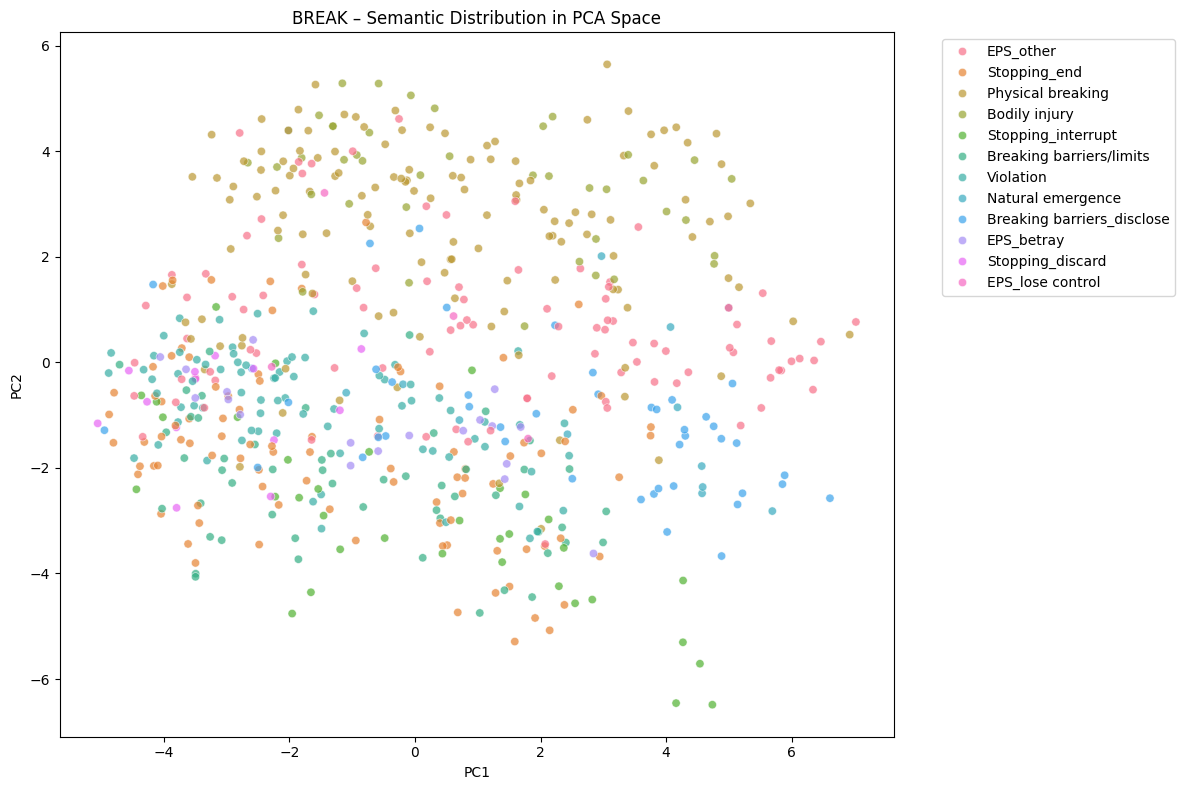

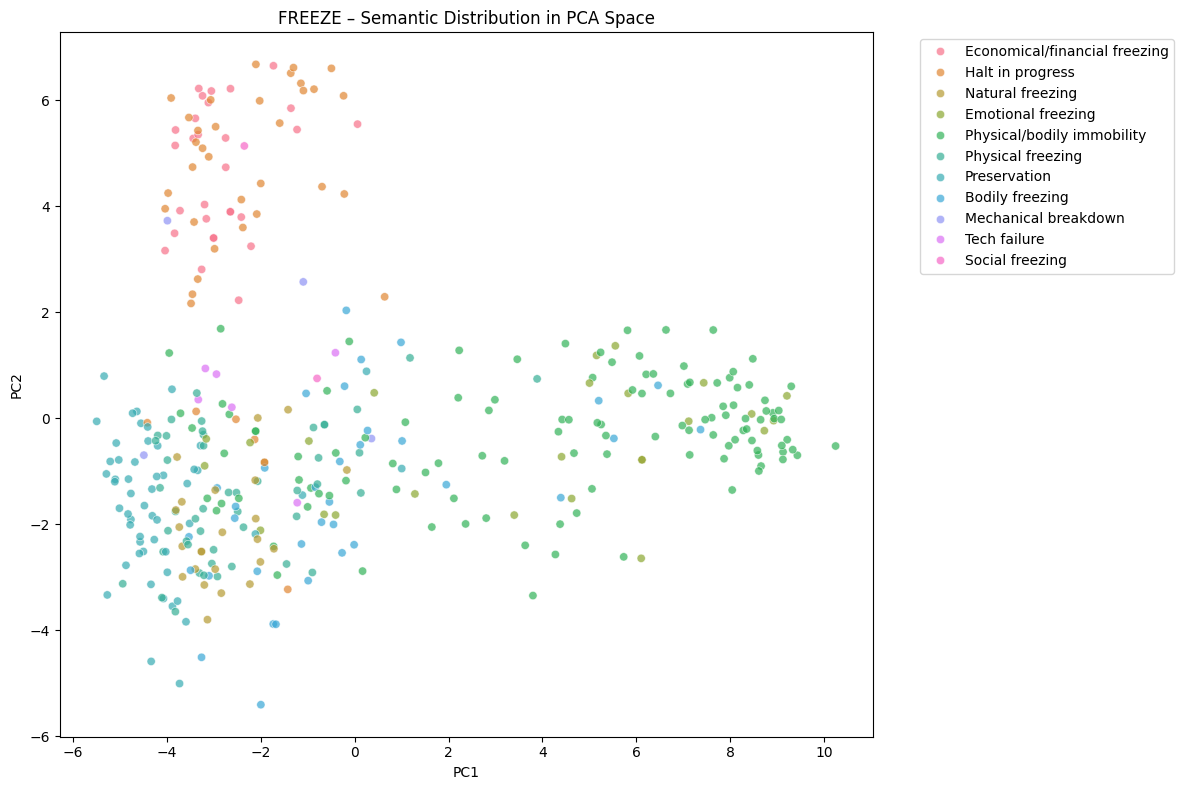

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for verb in ["break", "freeze"]:
    sub = df[df["verb"] == verb]
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=sub, x="PC1", y="PC2", hue="sense", alpha=0.7)
    plt.title(f"{verb.upper()} – Semantic Distribution in PCA Space")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


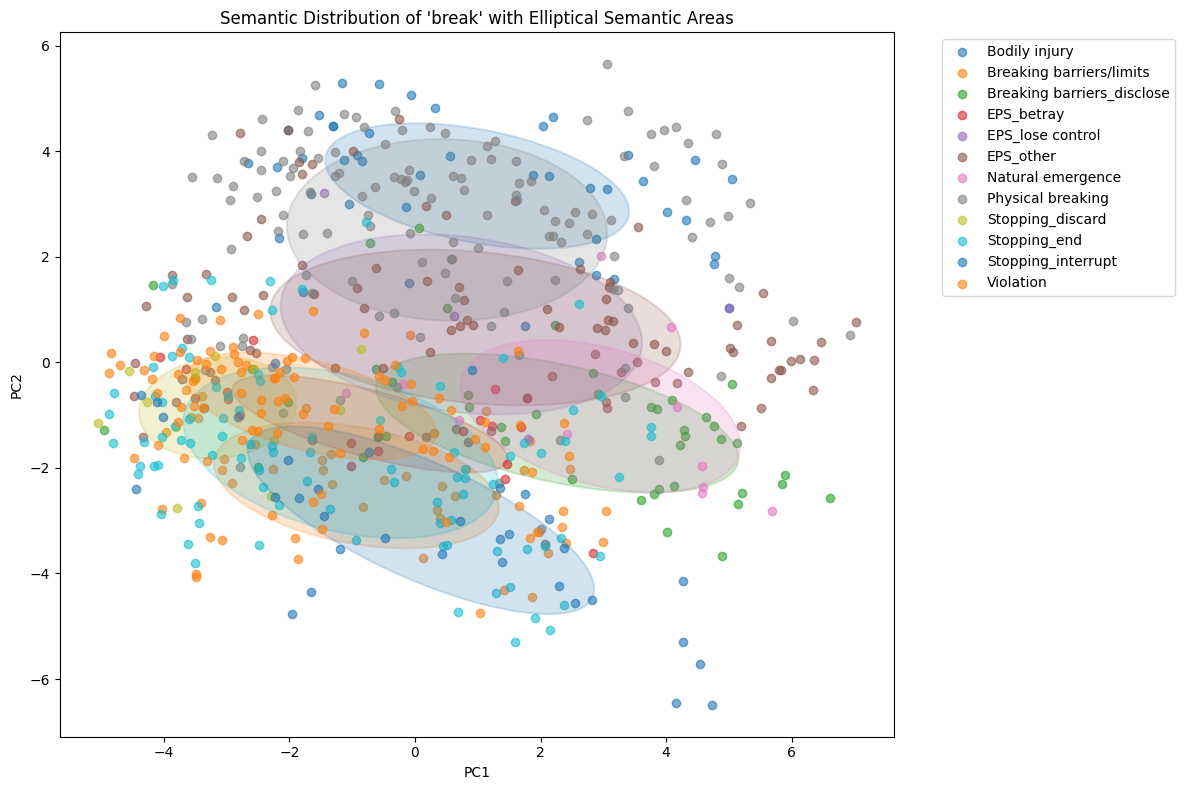

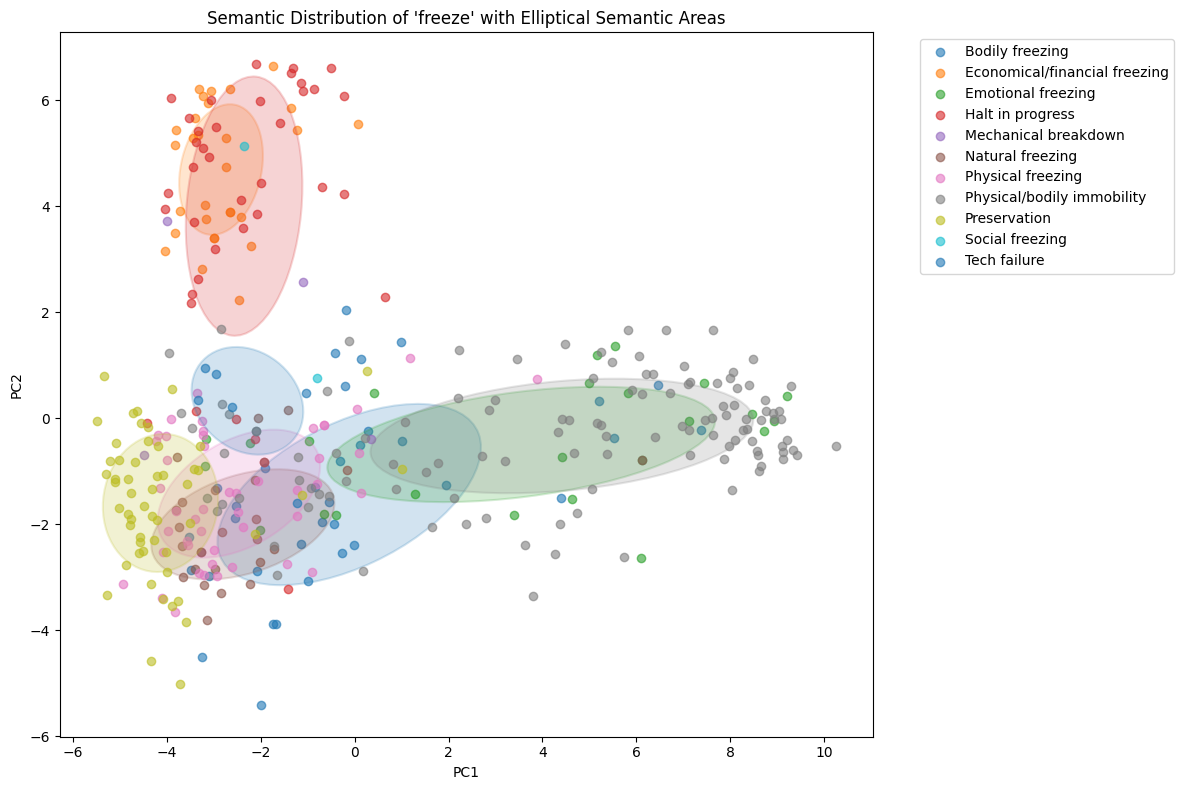

In [ ]:
from matplotlib.patches import Ellipse

for verb in ["break", "freeze"]:
    sub = df[df["verb"] == verb]
    plt.figure(figsize=(12, 8))
    palette = sns.color_palette("tab10", n_colors=len(sub["sense"].unique()))

    for i, (sense, group) in enumerate(sub.groupby("sense")):
        x, y = group["PC1"], group["PC2"]
        color = palette[i % len(palette)]
        plt.scatter(x, y, alpha=0.6, label=sense, color=color)

        # 타원 (클러스터 확산 시각화)
        if len(x) >= 5:
            cov = np.cov(x, y)
            vals, vecs = np.linalg.eigh(cov)
            order = vals.argsort()[::-1]
            vals, vecs = vals[order], vecs[:, order]
            theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
            width, height = 2 * np.sqrt(vals)
            ellipse = Ellipse((x.mean(), y.mean()), width, height, angle=theta,
                              edgecolor=color, fc=color, lw=1.5, alpha=0.2)
            plt.gca().add_patch(ellipse)

    plt.title(f"Semantic Distribution of '{verb}' with Elliptical Semantic Areas")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
